In [1]:
import os 
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-GPU-f16670b1-ac4a-8a32-02cb-60439c6bf799/0/0"

In [2]:
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import EnergyBased, MaxSoftmax
from pytorch_ood.utils import OODMetrics, ToUnknown
from pytorch_ood.dataset.img import Textures
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import Compose, ToPILImage, Normalize, ToTensor, Resize, ToPILImage
import torch 
from torchvision import transforms 
from pytorch_ood.utils import ToRGB
from torchvision.datasets import ImageNet
from torchvision.models import resnet18, resnet101
from torch.utils.data import DataLoader 
import tqdm.notebook as tqdm 
import torchmetrics 
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from pytorch_ood.dataset.img import ImageNetR, ImageNetO, ImageNetA
from pytorch_ood.utils import OODMetrics
from pytorch_ood.detector import MaxSoftmax

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    ToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [3]:
from torch.optim import Adam, SGD
from pytorch_ood.loss import OutlierExposureLoss
from itertools import cycle

def train(outlier_set=10, iters=1000):
    dataset_out_train = ImageFolder(root=f"/data_slow/kirchheim/gan_oe/imagenet/{outlier_set}/", target_transform=ToUnknown(), transform=preprocess)
    train_out_loader = DataLoader(dataset_out_train, batch_size=64, num_workers=20, shuffle=True)

    dataset_in_train = ImageNet(split="train", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    imagenet_in_loader = DataLoader(dataset_in_train, batch_size=64, num_workers=20, shuffle=True)

    # in test set 
    dataset_in_test = ImageNet(split="val", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    test_in_loader = DataLoader(dataset_in_test, batch_size=256, num_workers=20)

    # ood test sets 
    imagenet_r = ImageNetR(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_r_loader = DataLoader(imagenet_r + dataset_in_test, batch_size=128, num_workers=12)
    
    imagenet_o = ImageNetO(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_o_loader = DataLoader(imagenet_o + dataset_in_test, batch_size=128, num_workers=12)

    imagenet_a = ImageNetA(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_a_loader = DataLoader(imagenet_a + dataset_in_test, batch_size=128, num_workers=12)
    
    
    model = resnet101(pretrained=True)
    model = model.cuda()

    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []
    perf_metrics = []

    current_auroc = None 

    it_train_in = iter(imagenet_in_loader)
    it_train_out = iter(train_out_loader)

    criterion = OutlierExposureLoss()
    bar = tqdm.tqdm(range(iters))

    for i in bar:
        try:
            x1, y1 = next(it_train_in)
            x2, y2 = next(it_train_out)
        except:
            it_train_in = iter(imagenet_in_loader)
            it_train_out = iter(train_out_loader)

        x = torch.cat([x1, x2])
        y = torch.cat([y1, y2])

        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        loss = criterion(y_hat, y)
        opti.zero_grad()
        loss.backward()
        opti.step()

        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        bar.set_postfix({"loss": mav, "AUROC": current_auroc})
    
    print(f"Evaluating... ")
    model.eval()
    with torch.no_grad():
        softmax = MaxSoftmax(model)
        energy = EnergyBased(model)
        
        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_a_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)
        

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_o_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_r_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        print(f"AUROC {i} -> {m['AUROC']:.3%}")
        current_auroc = m['AUROC']

    model.train()

    return perf_metrics


In [4]:
import pandas as pd 
dfs = []

for var in [0, 0.25, 0.5, 0.75, 1.0, 10.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]:
    print(f"Variance: {var}")
    metrics = train(var)
    df = pd.DataFrame(metrics)
    df["Variance"] = var 
    dfs.append(df)

Variance: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

AUROC 999 -> 63.906%
Variance: 0.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 58.837%
Variance: 0.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 54.567%
Variance: 0.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 67.663%
Variance: 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 85.033%
Variance: 10.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.790%
Variance: 1.25


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.623%
Variance: 1.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.813%
Variance: 1.75


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.972%
Variance: 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.782%
Variance: 2.5


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.936%
Variance: 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.544%
Variance: 4.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 88.222%
Variance: 5.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.939%
Variance: 6.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.649%
Variance: 7.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.731%
Variance: 8.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.835%
Variance: 9.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 87.829%


In [5]:
df = pd.concat(dfs)

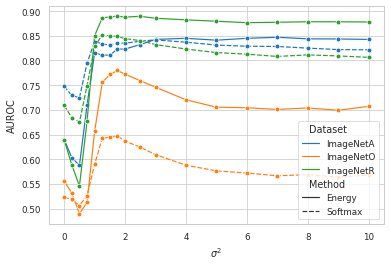

In [27]:
from matplotlib import rcParams
rcParams['pgf.texsystem'] = "pdflatex"

import seaborn as sb 
import matplotlib.pyplot as plt 

sb.set_style("whitegrid")
sb.set_context("paper")

df = pd.concat(dfs)
df.rename(columns = {"Variance": "$\sigma^2$"}, inplace = True)
d = df.groupby(["$\sigma^2$", "Dataset", "Method"]).mean()

# d["$\sigma^2$"] = d["Variance"]
sb.lineplot(data=d, x="$\sigma^2$", y="AUROC", hue="Dataset", style="Method", marker="o")
plt.savefig("img/imagenet-auroc-vs-variance.png", dpi=300)
plt.savefig("img/imagenet-auroc-vs-variance.pgf")

In [17]:
df

,AUROC,AUPR-IN,AUPR-OUT,ACC95TPR,FPR95TPR,Dataset,Iteration,Method
0,0.815251,0.400938,0.965551,0.505385,0.56110,ImageNetA,999,Softmax
1,0.852170,0.474999,0.971908,0.541679,0.51938,ImageNetA,999,Energy
2,0.521003,0.038434,0.969069,0.162654,0.86884,ImageNetO,999,Softmax
3,0.632610,0.059148,0.977346,0.202462,0.82744,ImageNetO,999,Energy
4,0.769016,0.664223,0.839990,0.538950,0.70768,ImageNetR,999,Softmax
5,0.847782,0.764554,0.892743,0.608700,0.59608,ImageNetR,999,Energy


In [7]:
df = pd.concat(dfs)
df = df[df["Variance"] == 2.0]
df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration &  Variance \\
Method &        &          &           &           &           &            &           \\
\midrule
MPS    &  79.98 &    42.86 &     95.41 &     49.69 &     59.22 &   99900.00 &    200.00 \\
\bottomrule
\end{tabular}



In [28]:
dfs_v2 = train(2.0)

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

AUROC 999 -> 88.852%


In [29]:
df = pd.DataFrame(dfs_v2)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  82.96 &    43.82 &     96.15 &     53.50 &     54.34 &   99900.00 \\
Softmax &  77.50 &    42.67 &     94.76 &     46.57 &     63.36 &   99900.00 \\
\bottomrule
\end{tabular}



In [30]:
df

,AUROC,AUPR-IN,AUPR-OUT,ACC95TPR,FPR95TPR,Dataset,Iteration,Method
0,0.837850,0.428738,0.970379,0.532266,0.53020,ImageNetA,999,Softmax
1,0.827045,0.374796,0.968710,0.537590,0.52408,ImageNetA,999,Energy
2,0.641242,0.067553,0.978953,0.261769,0.76576,ImageNetO,999,Softmax
3,0.773169,0.122002,0.987705,0.367538,0.65576,ImageNetO,999,Energy
4,0.845905,0.783707,0.893324,0.603150,0.60496,ImageNetR,999,Softmax
5,0.888518,0.817732,0.928089,0.699850,0.45024,ImageNetR,999,Energy


# Evaluate model without additional training 

In [31]:
# in test set 
dataset_in_test = ImageNet(split="val", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
test_in_loader = DataLoader(dataset_in_test, batch_size=256, num_workers=20)

# ood test sets 
imagenet_r = ImageNetR(root="/data_fast/kirchheim/datasets/", 
                       download=True, transform=preprocess, target_transform=ToUnknown())
imagenet_r_loader = DataLoader(imagenet_r + dataset_in_test, batch_size=128, num_workers=12)

imagenet_o = ImageNetO(root="/data_fast/kirchheim/datasets/", 
                       download=True, transform=preprocess, target_transform=ToUnknown())
imagenet_o_loader = DataLoader(imagenet_o + dataset_in_test, batch_size=128, num_workers=12)

imagenet_a = ImageNetA(root="/data_fast/kirchheim/datasets/", 
                       download=True, transform=preprocess, target_transform=ToUnknown())
imagenet_a_loader = DataLoader(imagenet_a + dataset_in_test, batch_size=128, num_workers=12)


model = resnet101(pretrained=True)
model = model.cuda()

perf_metrics = []

print(f"Evaluating... ")
model.eval()
with torch.no_grad():
    softmax = MaxSoftmax(model)
    energy = EnergyBased(model)

    ###
    metrics = OODMetrics()
    metrics_energy = OODMetrics()

    for x, y in imagenet_a_loader:
        logits = model(x.cuda())
        metrics.update(softmax.score(logits), y)
        metrics_energy.update(energy.score(logits), y)

    m = metrics.compute()
    m.update({
        "Dataset": "ImageNetA",
        "Iteration": 0,
        "Method": "Softmax"
    })
    perf_metrics.append(m)

    m = metrics_energy.compute()
    m.update({
        "Dataset": "ImageNetA",
        "Iteration": 0,
        "Method": "Energy"
    })
    perf_metrics.append(m)


    ###
    metrics = OODMetrics()
    metrics_energy = OODMetrics()

    for x, y in imagenet_o_loader:
        logits = model(x.cuda())
        metrics.update(softmax.score(logits), y)
        metrics_energy.update(energy.score(logits), y)

    m = metrics.compute()
    m.update({
        "Dataset": "ImageNetO",
        "Iteration": 0,
        "Method": "Softmax"
    })
    perf_metrics.append(m)

    m = metrics_energy.compute()
    m.update({
        "Dataset": "ImageNetO",
        "Iteration": 0,
        "Method": "Energy"
    })
    perf_metrics.append(m)

    ###
    metrics = OODMetrics()
    metrics_energy = OODMetrics()

    for x, y in imagenet_r_loader:
        logits = model(x.cuda())
        metrics.update(softmax.score(logits), y)
        metrics_energy.update(energy.score(logits), y)

    m = metrics.compute()
    m.update({
        "Dataset": "ImageNetR",
        "Iteration": 0,
        "Method": "Softmax"
    })
    perf_metrics.append(m)

    m = metrics_energy.compute()
    m.update({
        "Dataset": "ImageNetR",
        "Iteration": 0,
        "Method": "Energy"
    })
    perf_metrics.append(m)

    # print(f"AUROC {i} -> {m['AUROC']:.3%}")
    current_auroc = m['AUROC']

Evaluating... 


/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)
/home/kirchheim/anaconda3/envs/myenv/lib/python3.8/site-packages/torchmetrics/functional/classification/precision_recall_curve.py:156: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [32]:
df = pd.DataFrame(perf_metrics)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  76.77 &    43.99 &     94.92 &     44.26 &     65.34 &       0.00 \\
Softmax &  70.48 &    39.10 &     93.06 &     41.15 &     69.92 &       0.00 \\
\bottomrule
\end{tabular}



# Train on noise 

In [33]:
from pytorch_ood.dataset.img import UniformNoise

def train_noise(outlier_set=10, iters=1000):
    dataset_out_train = UniformNoise(length=80000, size=(224,224,3), 
                                     target_transform=ToUnknown(), transform=preprocess)
    train_out_loader = DataLoader(dataset_out_train, batch_size=64, num_workers=20, shuffle=True)

    dataset_in_train = ImageNet(split="train", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    imagenet_in_loader = DataLoader(dataset_in_train, batch_size=64, num_workers=20, shuffle=True)

    # in test set 
    dataset_in_test = ImageNet(split="val", root="/data_fast/kirchheim/datasets/imagenet-2012/", transform=preprocess)
    test_in_loader = DataLoader(dataset_in_test, batch_size=256, num_workers=20)

    # ood test sets 
    imagenet_r = ImageNetR(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_r_loader = DataLoader(imagenet_r + dataset_in_test, batch_size=128, num_workers=12)
    
    imagenet_o = ImageNetO(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_o_loader = DataLoader(imagenet_o + dataset_in_test, batch_size=128, num_workers=12)

    imagenet_a = ImageNetA(root="/data_fast/kirchheim/datasets/", 
                           download=True, transform=preprocess, target_transform=ToUnknown())
    imagenet_a_loader = DataLoader(imagenet_a + dataset_in_test, batch_size=128, num_workers=12)
    
    
    model = resnet101(pretrained=True)
    model = model.cuda()

    opti = SGD(model.parameters(), lr=0.001)

    criterion = OutlierExposureLoss(alpha=0.5)

    mav = 0.0
    mavs = []
    perf_metrics = []

    current_auroc = None 

    it_train_in = iter(imagenet_in_loader)
    it_train_out = iter(train_out_loader)

    criterion = OutlierExposureLoss()
    bar = tqdm.tqdm(range(iters))

    for i in bar:
        try:
            x1, y1 = next(it_train_in)
            x2, y2 = next(it_train_out)
        except Exception as e:
            print(e)
        except:
            it_train_in = iter(imagenet_in_loader)
            it_train_out = iter(train_out_loader)

        x = torch.cat([x1, x2])
        y = torch.cat([y1, y2])

        x = x.cuda()
        y = y.cuda()

        y_hat = model(x)
        loss = criterion(y_hat, y)
        opti.zero_grad()
        loss.backward()
        opti.step()

        mav = 0.2 * loss.item() + 0.8 * mav
        mavs.append(mav)

        bar.set_postfix({"loss": mav, "AUROC": current_auroc})
    
    print(f"Evaluating... ")
    model.eval()
    with torch.no_grad():
        softmax = MaxSoftmax(model)
        energy = EnergyBased(model)
        
        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_a_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetA",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)
        

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_o_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetO",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        ###
        metrics = OODMetrics()
        metrics_energy = OODMetrics()
        
        for x, y in imagenet_r_loader:
            logits = model(x.cuda())
            metrics.update(softmax.score(logits), y)
            metrics_energy.update(energy.score(logits), y)

        m = metrics.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Softmax"
        })
        perf_metrics.append(m)
        
        m = metrics_energy.compute()
        m.update({
            "Dataset": "ImageNetR",
            "Iteration": i,
            "Method": "Energy"
        })
        perf_metrics.append(m)

        print(f"AUROC {i} -> {m['AUROC']:.3%}")
        current_auroc = m['AUROC']

    model.train()

    return perf_metrics


In [34]:
noise_metrics = train_noise()

  0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating... 
AUROC 999 -> 84.942%


In [35]:
df = pd.DataFrame(noise_metrics)
# df = df[df["Variance"] == 2.0]
# df["Method"] = "MPS"
print((df.groupby("Method").mean() * 100).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUROC &  AUPR-IN &  AUPR-OUT &  ACC95TPR &  FPR95TPR &  Iteration \\
Method  &        &          &           &           &           &            \\
\midrule
Energy  &  78.03 &    43.66 &     94.78 &     45.46 &     64.31 &   99900.00 \\
Softmax &  70.28 &    36.95 &     92.50 &     40.13 &     71.42 &   99900.00 \\
\bottomrule
\end{tabular}

